# Regularization Techniques in a Nutshell

https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
n_per_clust = 200

th = np.linspace(0, 4*np.pi, n_per_clust)

#radios respecto al origen de cada clase
r1 = 10
r2 = 15

#genereamos los datos de cada clúster
a = [r1*np.cos(th) + np.random.randn(n_per_clust)*3, #coseno de theta + ruido
    r1*np.sin(th) + np.random.rand(n_per_clust)] 

b = [r2*np.cos(th) + np.random.rand(n_per_clust),
    r2*np.sin(th) + np.random.randn(n_per_clust)*3]

#etiquetas
labels_np = np.vstack((np.zeros((n_per_clust, 1)), np.ones((n_per_clust, 1))))
#vector columna de 0s para categoría A y 1s para B

#concatenar los dos objetos (cada uno es una lista de 2 vectores) en una matrix
data_np = np.hstack((a,b)).T

#convertimos a objetos de pytorch
X = torch.tensor(data_np).float()
y = torch.tensor(labels_np).float()

# X, y = data_np, labels_np

In [3]:
X[:3]

tensor([[ 5.1970,  0.8809],
        [14.7902,  1.5771],
        [12.3093,  1.3565]])

Mostramos los datos

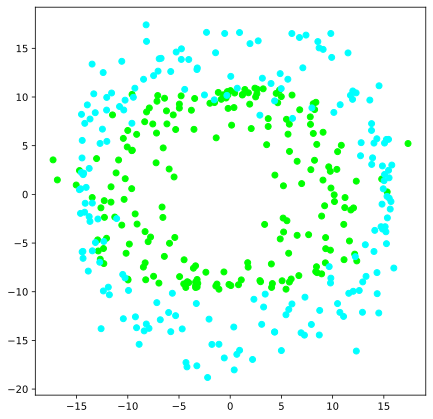

In [4]:
fig = plt.figure(figsize=(7,7))
plt.scatter(X[np.where(y==0)[0], 0], X[np.where(y==0)[0], 1], color="lime")
plt.scatter(X[np.where(y==1)[0], 0], X[np.where(y==1)[0], 1], color="aqua");

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [7]:
batch_size = 16 #suelen ser potencias de 2

train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(test_data,
                        batch_size=test_data.tensors[0].shape[0])
#train_data.tensors[0] accede a las características X
#para predicciones del modelo, los lotes son individuales

## 1. Dropout

Recordemos que dropout solo se implementará durante el entrenamiento

La técnica inhibía de forma aleatoria muestras aleatorias con una probabilidad determinada sobre cada nodo, y aquellos que no sean inhibidos durante esa epoch de entrenamiento, serán escalados hacia arriba

<img src="dropout details.jpg" alt="info" width=700>

In [8]:
class Model(nn.Module):
    
    def __init__(self, dropout_rate):
        
        super().__init__()
        
        self.inp = nn.Linear(train_data.tensors[0].shape[1], 128)
        self.hid = nn.Linear(128,128)
        self.out = nn.Linear(128,1)
        
        
        #el atributo referente a la proporción de dropout
        self.dr = dropout_rate
        
    def forward(self, x):
        
        x = F.relu(self.inp(x))
        #dropout tras esta capa, tan solo aplicado si el booleano self.training = True
        x = F.dropout(x, p=self.dr,
                     training=self.training)
        
        x = F.relu(self.hid(x))
        
        x = F.dropout(x, p=self.dr, #dropout (si el modelo esta en modo train())
                     training=self.training)
        
        x = self.out(x) #aquí no aplicamos dropout, ya que al haber un nodo inhibiría la salida del modelo
        
        return x

In [9]:
model = Model(dropout_rate=0.25)

#testeando una inferencia del modelo
model(torch.rand((1,2)))

tensor([[-0.0257]], grad_fn=<AddmmBackward0>)

In [10]:
def create_model(dr_rate):
    
    model = Model(dr_rate)
    loss_func = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(params=model.parameters(),
                       lr=0.001)
    
    return model, loss_func, optim

In [11]:
n_epochs = 100

In [12]:
from tqdm import tqdm

In [13]:
def train_model(model, loss_func, optim):
    
    train_accs = []
    test_accs = []
    
    
    for epoch in tqdm(range(n_epochs)):
        
        model.train() #activamos el modo train(). Esto servirá para activar dropout

        
        batch_accs = []
        
        for (X_batch, y_batch) in train_loader:
            
            y_hat = model(X_batch)
            
            loss = loss_func(y_hat, y_batch)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            

            batch_accs.append(100*torch.mean(((y_hat>0) == y_batch).float()).item())
        
        train_accs.append(np.mean(batch_accs))
        
        #test
        model.eval() #aseguramos desactivar dropout
        X_test, y_test = next(iter(test_loader)) #extraemos los datos del generador
        preds = model(X_test)
        test_accs.append(100*torch.mean(((preds>0) == y_test).float()).item())
        
    
    return train_accs, test_accs

In [14]:
dropout_rate = 0.2
model, loss_func, optim = create_model(dropout_rate)

train_accs, test_accs = train_model(model, loss_func, optim)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.92it/s]


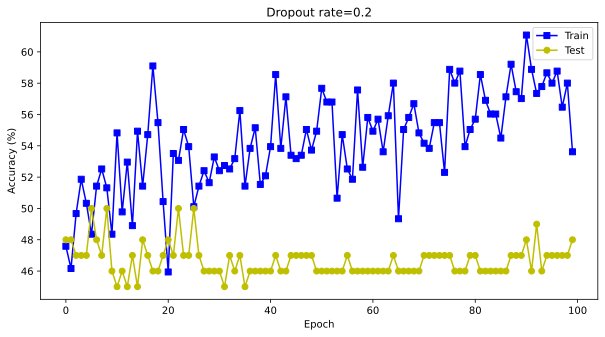

In [15]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_accs, "bs-")
plt.plot(test_accs, "yo-");
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);
plt.title(f"Dropout rate={dropout_rate}");

## L1 Loss

- Esta técnica de regularización añade mayor valor a la función de pérdidas o error en caso de que los pesos se hagan muy grandes, por lo que a mayor error, con más magnitud se actualizarán los pesos, **lo que implica que para algunas características se compriman sus pesos hasta el punto de llegar a ser 0, siendo estas las menos importantes para la predicción**

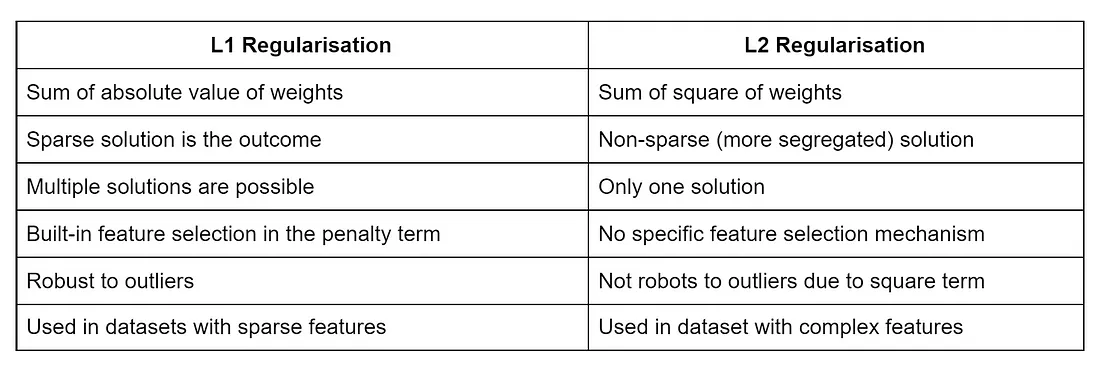

In [16]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.inp = nn.Linear(train_data.tensors[0].shape[1], 128)
        self.hid = nn.Linear(128,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, x):
        
        x = F.relu(self.inp(x))
        x = F.relu(self.hid(x))
        x = self.out(x)
        
        return x
        

In [17]:
def create_model():
    
    model = Model()
    loss_func = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(params=model.parameters(),
                       lr=0.005)
    
    return model, loss_func, optim

### **Función que entrena el modelo y pone en marcha la regularización L1**

### El coeficiente de penalización $\large\lambda$ estaba formado por $\large{\frac{\alpha}{2\cdot m}}$ 

<img src="./l1 coefficient detail.jpg" alt="info" width=300>

Realmente el parámetro ajustable en este caso es $\alpha$, que compone el resultado del coeficiente, pero lo llamaremos $\lambda$

<img src="..\l1 extra formula.jpg" alt="info" width=300>

In [18]:
n_epochs = 100

def train_model(l1_lambda):
    
    train_accs = []
    test_accs = []
    losses = []
    
    #obtenemos el número de pesos entrenables (en este caso sin bias) en cada capa, y los sumamos
    n_weights = sum([param[1].numel() for param in model.named_parameters() if "bias" not in param[0]])    
    
#     n_weights = 0
#     for param_name, param in model.named_parameters():
#         if "bias" not in param_name:
#             n_weights+=param.numel()    

    for epoch in tqdm(range(n_epochs)):
        
        batch_accs = []
        batch_losses = []
        
        for X_batch, y_batch in train_loader:
            
            y_hat = model(X_batch) #forward pass
            
            loss = loss_func(y_hat, y_batch) #measure loss
            
            #añadiendo el término de L1 a la pérdida
            l1_term = torch.tensor(0., requires_grad=True) #inincializará como 0 (requerirá calcular gradiente ya que se suma a la pérdida)
            for param_name, param in model.named_parameters():
                if "bias" not in param_name:
                    l1_term = l1_term + torch.sum(torch.abs(param))
                    #añadirá al término de penalización la suma de los valores absolutos de cada matriz de pesos
            
            loss += l1_lambda*l1_term/n_weights 
            #el término l1_lambda escala hacia abajo la penalización L1
            

            
            optim.zero_grad()
            loss.backward() #compute gradients
            optim.step() #update parameters
            
            batch_accs.append(100*torch.mean((torch.argmax(y_hat,axis=1) == y_batch).float()).item() )
            batch_losses.append(loss.item())
        
        train_accs.append(np.mean(batch_accs))
        losses.append(np.mean(batch_losses))
        
        X_test, y_test = next(iter(test_loader))
        pred_labels = torch.argmax(model(X_test), axis=1)
        test_accs.append(100*torch.mean((pred_labels==y_test).float()).item())
        
    return train_accs, test_accs, losses

In [19]:
l1_lambda = 0.002
model, loss_func, optim = create_model()

train_accs, test_accs, losses = train_model(l1_lambda)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.45it/s]


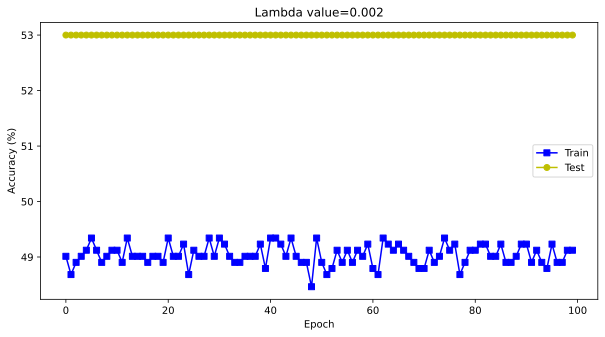

In [20]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_accs, "bs-")
plt.plot(test_accs, "yo-");
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);
plt.title(f"Lambda value={l1_lambda}");

## L2 Regularization o Ridg/ Weight Decay

Va a provocar unos pesos muy suaves dado que al elevar al cuadrado los pesos, aquellos pesos muy altos deberán hacerse mucho más pequeños, por lo que es muy **sensible a pesos altos**

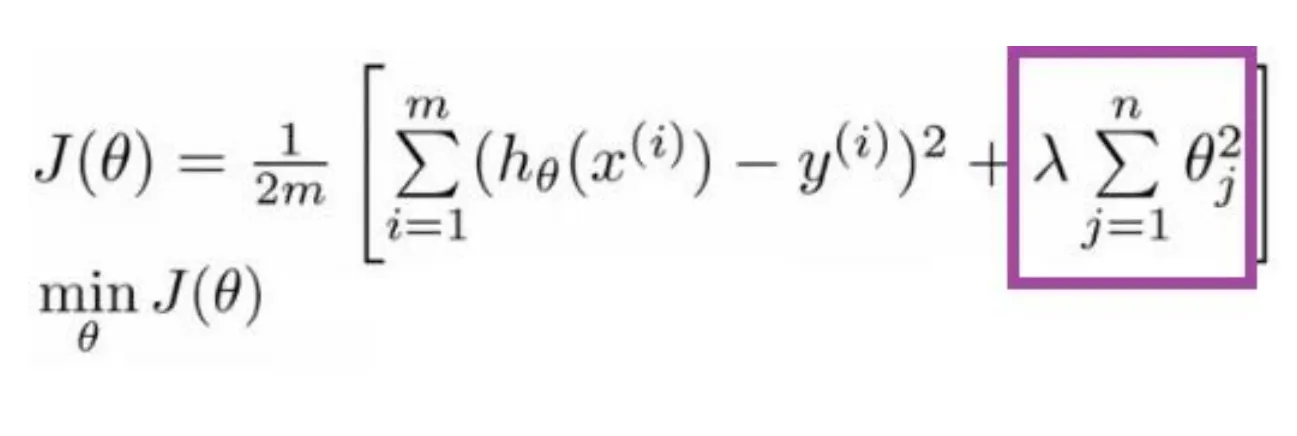

<img src="l2 weight decay details.jpg" alt="info" width=700>

### Ajustaremos el tamaño del coeficiente de penalización $\large\lambda$ a través del parámetro `l2_lambda`

In [21]:
def create_model(l2_lambda):
    
    model = Model()
    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(params=model.parameters(),
                       lr=0.005,
                       weight_decay=l2_lambda) #aquí se ubicará el parámetro
    
    return model, loss_func, optim

In [22]:
n_epochs = 100

def train_model(model, loss_func, optim):
    
    train_accs = []
    test_accs = []
    losses = []
    
    for epoch in tqdm(range(n_epochs)):
        
        
        batch_accs = []
        batch_loss = []
        
        for (X_batch, y_batch) in train_loader:
            
            y_hat = model(X_batch)
            
            loss = loss_func(y_hat, y_batch)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            

            batch_accs.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y_batch).float()).item())
            batch_loss.append(loss.item())
        
        #al final de cada epoch
        train_accs.append(np.mean(batch_accs))
        losses.append(np.mean(batch_loss))
        
        #test
        X_test, y_test = next(iter(test_loader)) #extraemos los datos del generador
        preds = model(X_test)
        test_accs.append(100*torch.mean((torch.argmax(preds, axis=1) == y_test).float()).item())
        
    
    return train_accs, test_accs, losses

In [23]:
l2_lambda = 0.01

model, loss_func, optim = create_model(l2_lambda)

train_accs, test_accs, losses = train_model(model, loss_func, optim)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.09it/s]


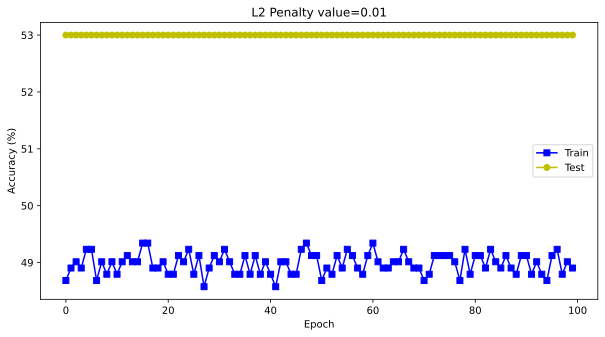

In [24]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_accs, "bs-")
plt.plot(test_accs, "yo-");
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);
plt.title(f"L2 Penalty value={l2_lambda}");